<a id='intro'></a>
*To [Table of Contents](#toc)*
# Image Super Resolution
## Applied Machine Learning Systems 2
### University College London
#### Department of Electronic and Electrical Engineering
**Student Number:** $20167036$

<a id='toc'></a>
## Table of Contents:
1. [Introduction](#intro)
2. [Loading Data](#load) 
3. [Data Visualisation and Pre-Processing](#pre-processing)
4. [Construct Models](#construct) 
5. [Model Training](#training)
6. [Performance Evaluation](#evaluate)



<a id='load'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/load.png" alt="Drawing" style="height: 100px;"/>
# Loading Data

Import core libraries

In [2]:
# Import some core data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation modules
from PIL import Image

# File system modules
import os
import sys

os.chdir('..')


# Import some homemade modules
from Modules import user_interface as ui

Define a function for loading images

In [3]:
def loadImages(directory, file_extension='.png', loading_message = 'Loading images...'):
    
    # List container to hold image arrays
    images = []
    
    # Generate a sorted list of filenames for all images found in directory
    imgFiles = sorted([filename for filename in os.listdir(directory) if file_extension in filename])
    
    # Number of images to load counting from 0
    numImgs  = len(imgFiles) - 1 
    
    # Load image files from directory
    for i,filename in enumerate(imgFiles):
        
        img = Image.open(directory + filename) # Open image with Pillow function
        images.append(np.asarray(img))         # Append to image list as a numpy array
        
        # Print loading progress on every tenth and last image
        if not i % 10 or not i % numImgs:
            
            # Use print progress function from homemade user-interface module
            ui.print_progress(iteration = i,
                              total     = numImgs,
                              message   = loading_message)
    
    # Return the loaded images
    return images

Load images

In [17]:
# Bi-cubic x2 downscaled  images
x2_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X2/',
                         file_extension  = '.png',
                         loading_message = 'Loading [x2] Bi-Cubic Downsampled Training Images') 
x2_bc_test  = []

# Bi-cubic x3 downscaled  images
x3_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X3/',
                         file_extension  = '.png',
                         loading_message = 'Loading [x3] Bi-Cubic Downsampled Training Images') 
x3_bc_test  = []

# Bi-cubic x4 downscaled  images
x4_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X4/',
                         file_extension  = '.png',
                         loading_message = 'Loading [x4] Bi-Cubic Downsampled Training Images') 
x4_bc_test  = []

y_train     = [] # Original high-res training images
y_test      = [] # Original high-res testing images

Loading [x2] Bi-Cubic Downsampled Training Images |████████████████████| 100.0% 
Loading [x3] Bi-Cubic Downsampled Training Images |████████████████████| 100.0% 
Loading [x4] Bi-Cubic Downsampled Training Images |████████████████████| 100.0% 


<a id='pre-processing'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/visualisation.png" alt="Drawing" style="height: 100px;"/>
# Data Visualisation and Pre-Processing

Use `gridspec` to create custom layouts for `subplots` and then draw frames on low-resolution images using `matplotlib.patches` to display varying image quality.

In [25]:
x4_bc_train[2][0:10,0:10].shape

(10, 10, 3)

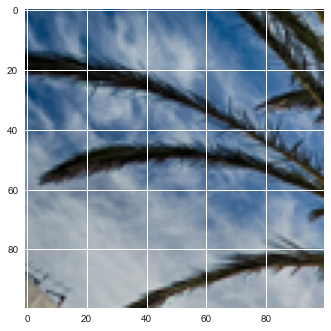

In [33]:
plt.imshow(x3_bc_train[2][0:100,0:100])

AttributeError: module 'matplotlib.pyplot' has no attribute 'patches'

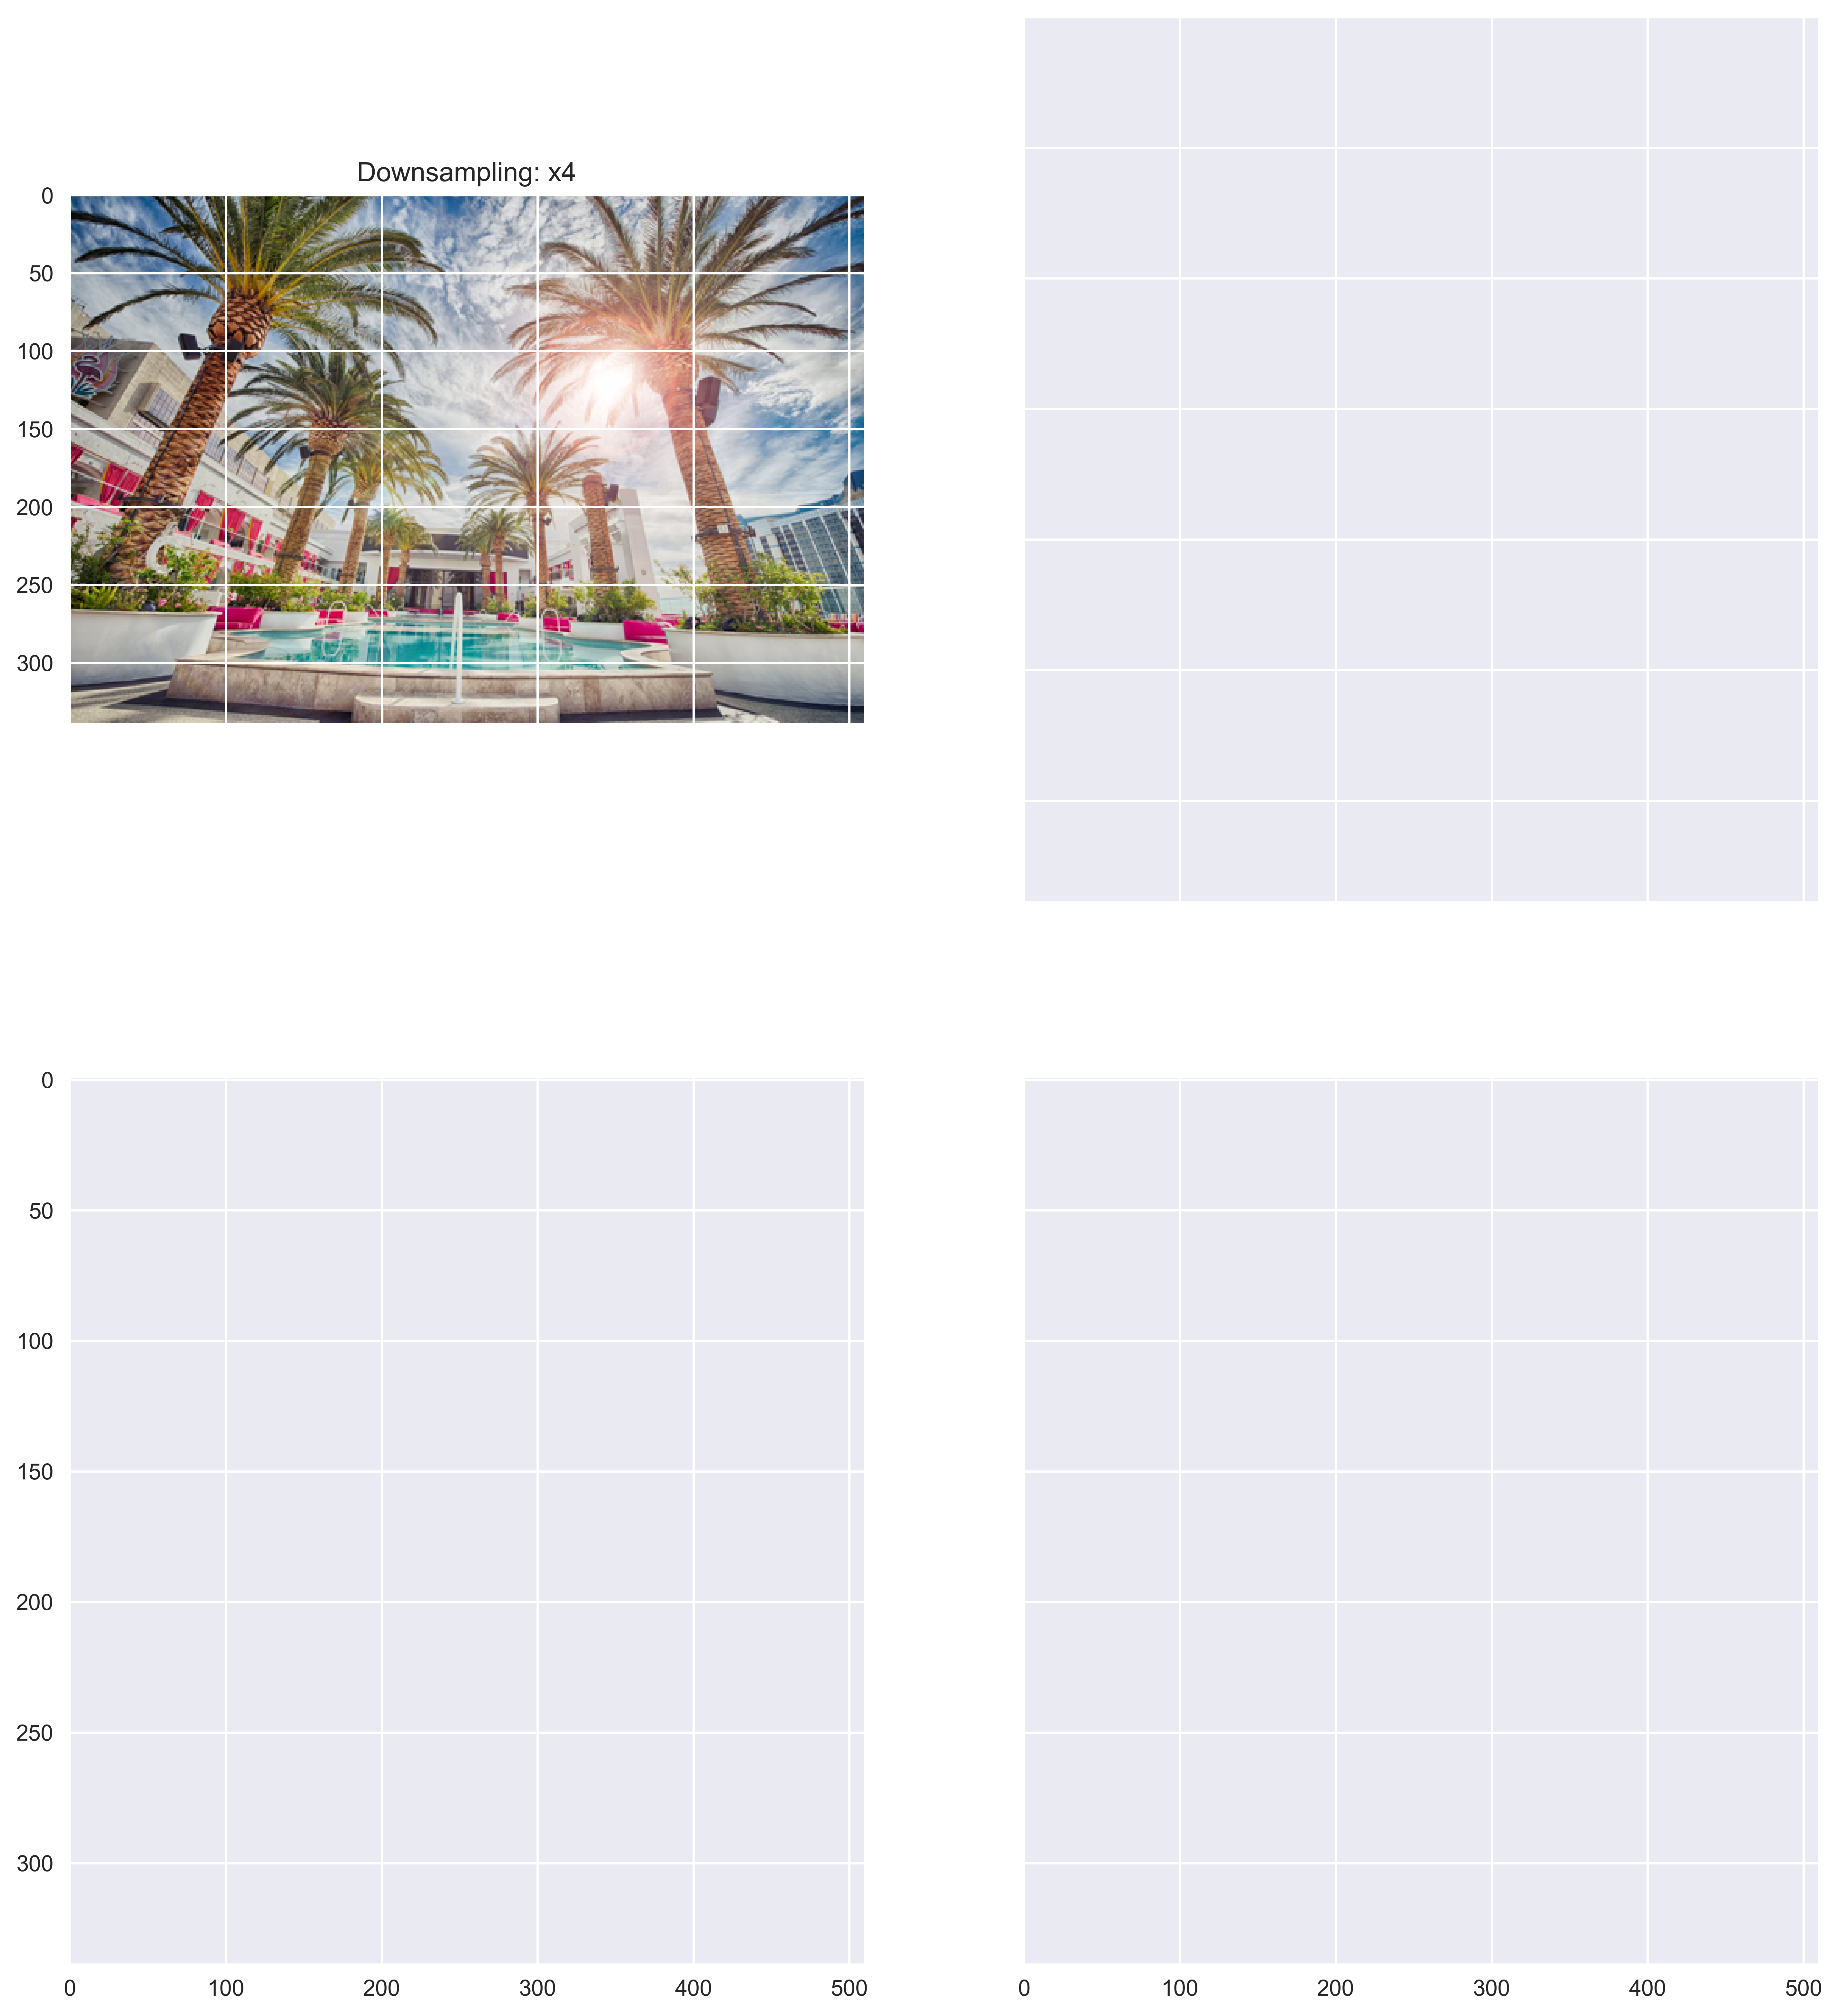

In [22]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(14,16), dpi = 500, sharey = True, sharex = True)

ax[0][0].set_title('Downsampling: x4')
ax[0][0].imshow(x4_bc_train[2])
rect = plt.patches.Rectangle((100,100),50,50,edgecolor='r')
ax[0][0].add_patch(rect)

ax[0][1].set_title('Downsampling: x3')
ax[0][1].imshow(x3_bc_train[2][])

ax[1][0].set_title('Downsampling: x2')
ax[1][0].imshow(x2_bc_train[2])

# Turn of grid-lines
for subplot in ax.ravel():
    subplot.set_xticks([])
    subplot.set_yticks([])

plt.suptitle('Flanny and the Tranagans')
plt.tight_layout()
plt.show()


<a id='construct'></a>
*Back to [Table of Contents](#toc)*
# Construct Models

<a id='training'></a>
*Back to [Table of Contents](#toc)*
# Model Training

<a id='evaluate'></a>
*Back to [Table of Contents](#toc)*
# Performance Evaluation

# Credits



Images: <a href="www.flaticon.com">Flaticon.com</a>. <br>
This notebook has been designed using resources from <a href="www.flaticon.com">Flaticon.com </a>